In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.models as models
import matplotlib.pyplot as plt # For accuracy plot
from tqdm import tqdm # For progress bars
from data_loader import get_cifar100_loaders
from evaluation_utils import (evaluate_model, plot_confusion_matrix,
                              visualize_misclassified, get_cifar100_class_names)

In [4]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name="resnet18"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    model.to(device)
    best_accuracy = 0.0
    model_save_path = f'{model_name}_cifar100_best.pth'

    # ---> NEW: Store epoch-wise accuracy for potential plotting later if needed <---
    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Simplified training loop using tqdm for progress bar
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Update progress bar description
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train / total_train
        train_acc_history.append(epoch_acc_train)

        # --- Per-Epoch Evaluation (Keep for monitoring & saving best model) ---
        model.eval()
        correct_test = 0
        total_test = 0
        # Simplified validation loop using tqdm
        test_iterator = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in test_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_acc_test = 100.0 * correct_test / total_test
        test_acc_history.append(epoch_acc_test)
        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc_train:.2f}% | '
              # ---> Use the calculated test accuracy here <---
              f'Test Acc: {epoch_acc_test:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f} | '
              f'Duration: {epoch_duration:.2f}s')

        scheduler.step()

        if epoch_acc_test > best_accuracy:
            best_accuracy = epoch_acc_test
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f'>>> Best model saved to {model_save_path} with Test Accuracy: {best_accuracy:.2f}%')
            except Exception as e:
                 print(f"Lỗi khi lưu model: {e}")

    print('Finished Training')
    print(f'Best Validation Accuracy achieved during training: {best_accuracy:.2f}%')

    # ---> Return the trained model (or load the best one) and histories <---
    # Optionally load the best saved model state before final evaluation
    print(f"Loading best model state from {model_save_path} for final evaluation...")
    try:
        model.load_state_dict(torch.load(model_save_path))
    except Exception as e:
        print(f"Could not load best model state: {e}. Evaluating with the final model state.")

    return model, train_acc_history, test_acc_history


Sử dụng thiết bị: cpu
Đang tải dữ liệu CIFAR-100 (resize: 224x224)...
Đã tải xong CIFAR-100.
Số lượng ảnh Train: 50000
Số lượng ảnh Test: 10000
Kích thước ảnh: 224x224
Sử dụng Data Augmentation: True
Khởi tạo ResNet18 pre-trained model...
Đã thay thế lớp cuối cùng bằng lớp Linear(512, 100)
Bắt đầu fine-tuning ResNet18...


Epoch 1/20 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]/home/ngo/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/20 [Val]: 100%|██████████| 157/157 [01:40<00:00,  1.56it/s]


Epoch 1/20 | Train Loss: 3.8214 | Train Acc: 14.35% | Test Acc: 44.33% | LR: 0.001000 | Duration: 1540.43s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 44.33%


Epoch 2/20 [Val]: 100%|██████████| 157/157 [01:25<00:00,  1.84it/s]


Epoch 2/20 | Train Loss: 2.5720 | Train Acc: 36.21% | Test Acc: 58.62% | LR: 0.001000 | Duration: 1472.11s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 58.62%


Epoch 3/20 [Val]: 100%|██████████| 157/157 [01:39<00:00,  1.57it/s]


Epoch 3/20 | Train Loss: 2.1155 | Train Acc: 45.65% | Test Acc: 65.27% | LR: 0.001000 | Duration: 1507.06s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 65.27%


Epoch 4/20 [Val]: 100%|██████████| 157/157 [01:33<00:00,  1.69it/s]


Epoch 4/20 | Train Loss: 1.8907 | Train Acc: 50.17% | Test Acc: 69.15% | LR: 0.001000 | Duration: 1544.45s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 69.15%


Epoch 5/20 [Val]: 100%|██████████| 157/157 [01:32<00:00,  1.71it/s]


Epoch 5/20 | Train Loss: 1.7523 | Train Acc: 52.96% | Test Acc: 70.60% | LR: 0.001000 | Duration: 1471.39s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 70.60%


Epoch 6/20 [Val]: 100%|██████████| 157/157 [01:39<00:00,  1.57it/s]


Epoch 6/20 | Train Loss: 1.6569 | Train Acc: 55.50% | Test Acc: 71.96% | LR: 0.001000 | Duration: 1532.13s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 71.96%


Epoch 7/20 [Val]: 100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch 7/20 | Train Loss: 1.5849 | Train Acc: 56.99% | Test Acc: 73.03% | LR: 0.001000 | Duration: 1499.14s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 73.03%


Epoch 8/20 [Val]: 100%|██████████| 157/157 [01:38<00:00,  1.60it/s]


Epoch 8/20 | Train Loss: 1.5187 | Train Acc: 58.96% | Test Acc: 74.31% | LR: 0.001000 | Duration: 1484.68s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 74.31%


Epoch 9/20 [Val]: 100%|██████████| 157/157 [01:33<00:00,  1.68it/s]


Epoch 9/20 | Train Loss: 1.4611 | Train Acc: 59.88% | Test Acc: 74.75% | LR: 0.001000 | Duration: 1496.05s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 74.75%


Epoch 10/20 [Val]: 100%|██████████| 157/157 [01:43<00:00,  1.52it/s]


Epoch 10/20 | Train Loss: 1.4211 | Train Acc: 61.00% | Test Acc: 75.80% | LR: 0.001000 | Duration: 1492.96s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 75.80%


Epoch 11/20 [Val]: 100%|██████████| 157/157 [01:39<00:00,  1.57it/s]


Epoch 11/20 | Train Loss: 1.3795 | Train Acc: 61.80% | Test Acc: 76.32% | LR: 0.001000 | Duration: 1497.48s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 76.32%


Epoch 12/20 [Val]: 100%|██████████| 157/157 [01:38<00:00,  1.59it/s]


Epoch 12/20 | Train Loss: 1.3479 | Train Acc: 62.66% | Test Acc: 76.51% | LR: 0.001000 | Duration: 1495.39s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 76.51%


Epoch 13/20 [Val]: 100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


Epoch 13/20 | Train Loss: 1.3267 | Train Acc: 63.43% | Test Acc: 76.69% | LR: 0.001000 | Duration: 1523.17s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 76.69%


Epoch 14/20 [Val]: 100%|██████████| 157/157 [01:40<00:00,  1.57it/s]


Epoch 14/20 | Train Loss: 1.2824 | Train Acc: 64.49% | Test Acc: 77.46% | LR: 0.001000 | Duration: 1514.97s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 77.46%


Epoch 15/20 [Val]: 100%|██████████| 157/157 [01:24<00:00,  1.86it/s]


Epoch 15/20 | Train Loss: 1.2740 | Train Acc: 64.97% | Test Acc: 77.46% | LR: 0.001000 | Duration: 1506.38s


Epoch 16/20 [Val]: 100%|██████████| 157/157 [01:13<00:00,  2.12it/s]


Epoch 16/20 | Train Loss: 1.2401 | Train Acc: 65.51% | Test Acc: 78.29% | LR: 0.001000 | Duration: 1465.44s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 78.29%


Epoch 17/20 [Val]: 100%|██████████| 157/157 [01:31<00:00,  1.72it/s]


Epoch 17/20 | Train Loss: 1.2177 | Train Acc: 66.12% | Test Acc: 78.32% | LR: 0.001000 | Duration: 1499.85s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 78.32%


Epoch 18/20 [Val]: 100%|██████████| 157/157 [01:37<00:00,  1.61it/s]


Epoch 18/20 | Train Loss: 1.1941 | Train Acc: 66.81% | Test Acc: 78.20% | LR: 0.001000 | Duration: 1505.07s


Epoch 19/20 [Val]: 100%|██████████| 157/157 [01:39<00:00,  1.57it/s]


Epoch 19/20 | Train Loss: 1.1777 | Train Acc: 67.29% | Test Acc: 78.96% | LR: 0.001000 | Duration: 1518.14s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 78.96%


Epoch 20/20 [Val]: 100%|██████████| 157/157 [01:38<00:00,  1.59it/s]


Epoch 20/20 | Train Loss: 1.1698 | Train Acc: 67.51% | Test Acc: 79.26% | LR: 0.001000 | Duration: 1488.70s
>>> Best model saved to 2_ResNet18_cifar100_best.pth with Test Accuracy: 79.26%
Finished Training
Best Validation Accuracy achieved during training: 79.26%
Loading best model state from 2_ResNet18_cifar100_best.pth for final evaluation...

--- Performing Final Evaluation on Test Set ---
Evaluating on test set...


  0%|          | 0/157 [00:02<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

        apple       0.91      0.87      0.89       100
aquarium_fish       0.95      0.87      0.91       100
         baby       0.74      0.65      0.69       100
         bear       0.73      0.74      0.74       100
       beaver       0.66      0.65      0.66       100
          bed       0.79      0.83      0.81       100
          bee       0.81      0.90      0.85       100
       beetle       0.92      0.65      0.76       100
      bicycle       0.95      0.93      0.94       100
       bottle       0.91      0.90      0.90       100
         bowl       0.68      0.67      0.67       100
          boy       0.59      0.57      0.58       100
       bridge       0.73      0.88      0.80       100
          bus       0.85      0.69      0.76       100
    butterfly       0.76      0.90      0.83       100
        camel       0.90      0.82      0.86       100
          can       0.86      0.86      

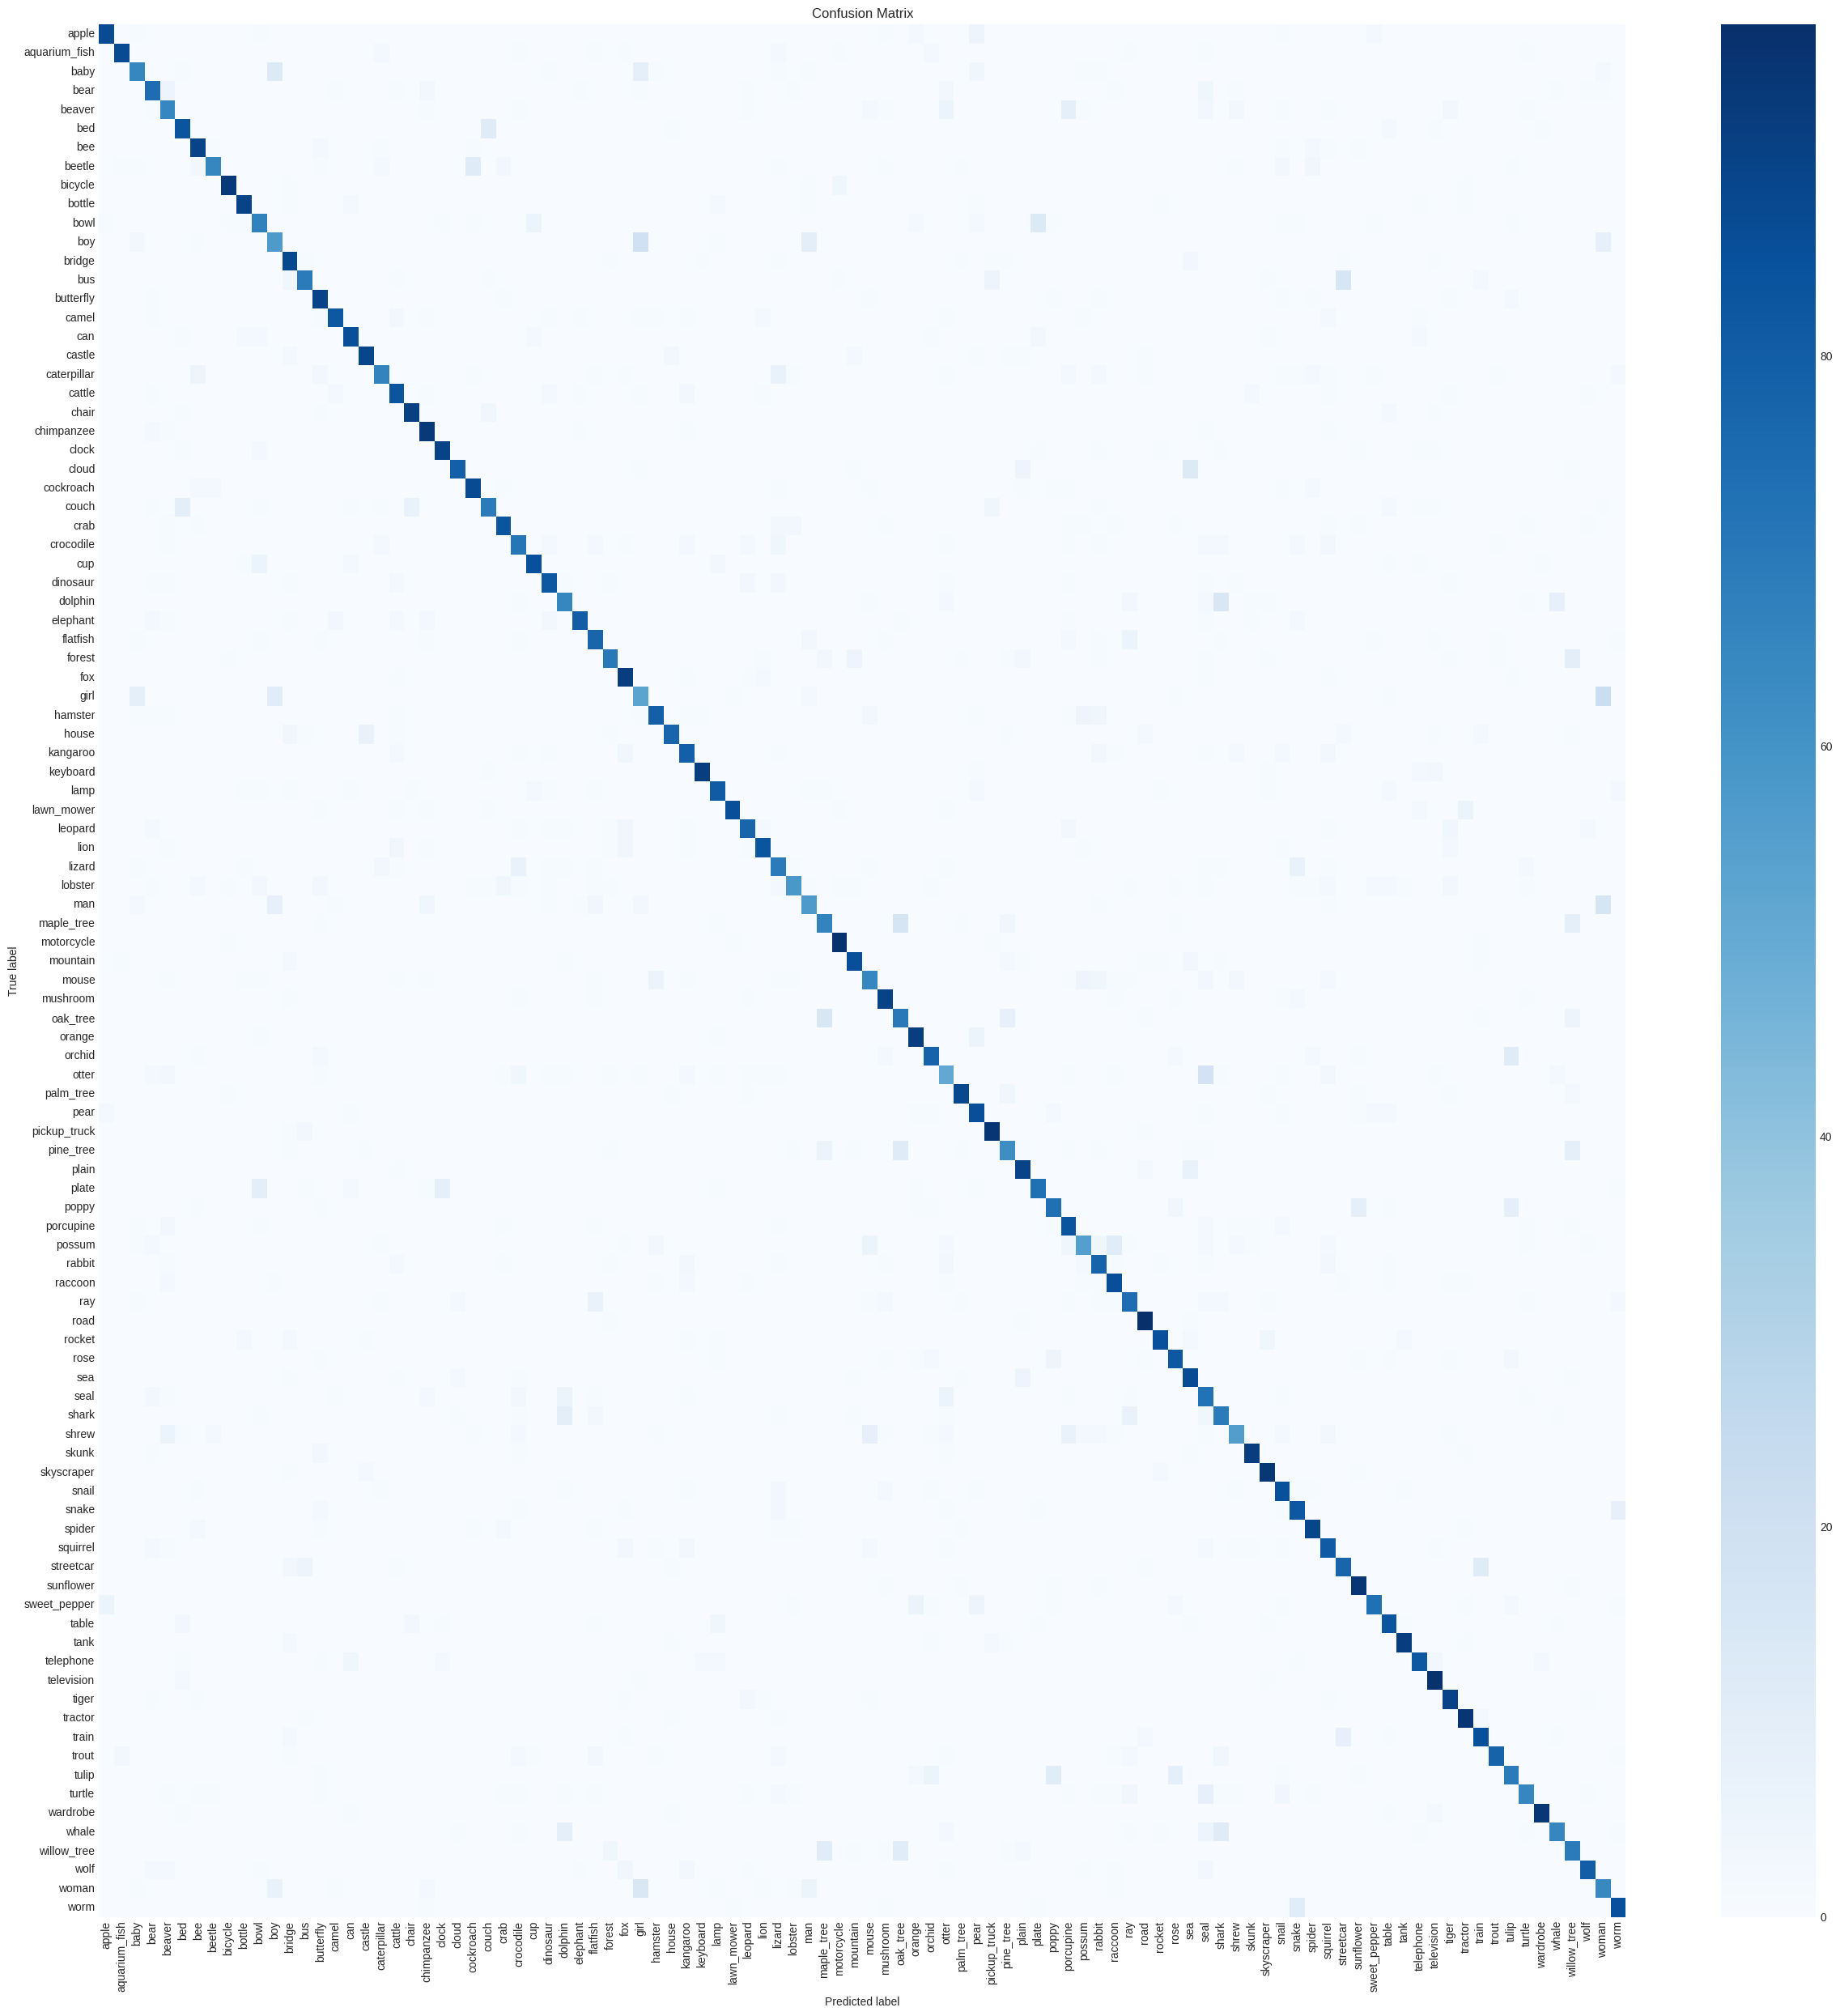


Searching for 25 misclassified images...


/home/ngo/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/157 [00:01<?, ?it/s]

Visualizing 25 misclassified images...
Misclassified images visualization saved to 2_ResNet18_misclassified_25.png


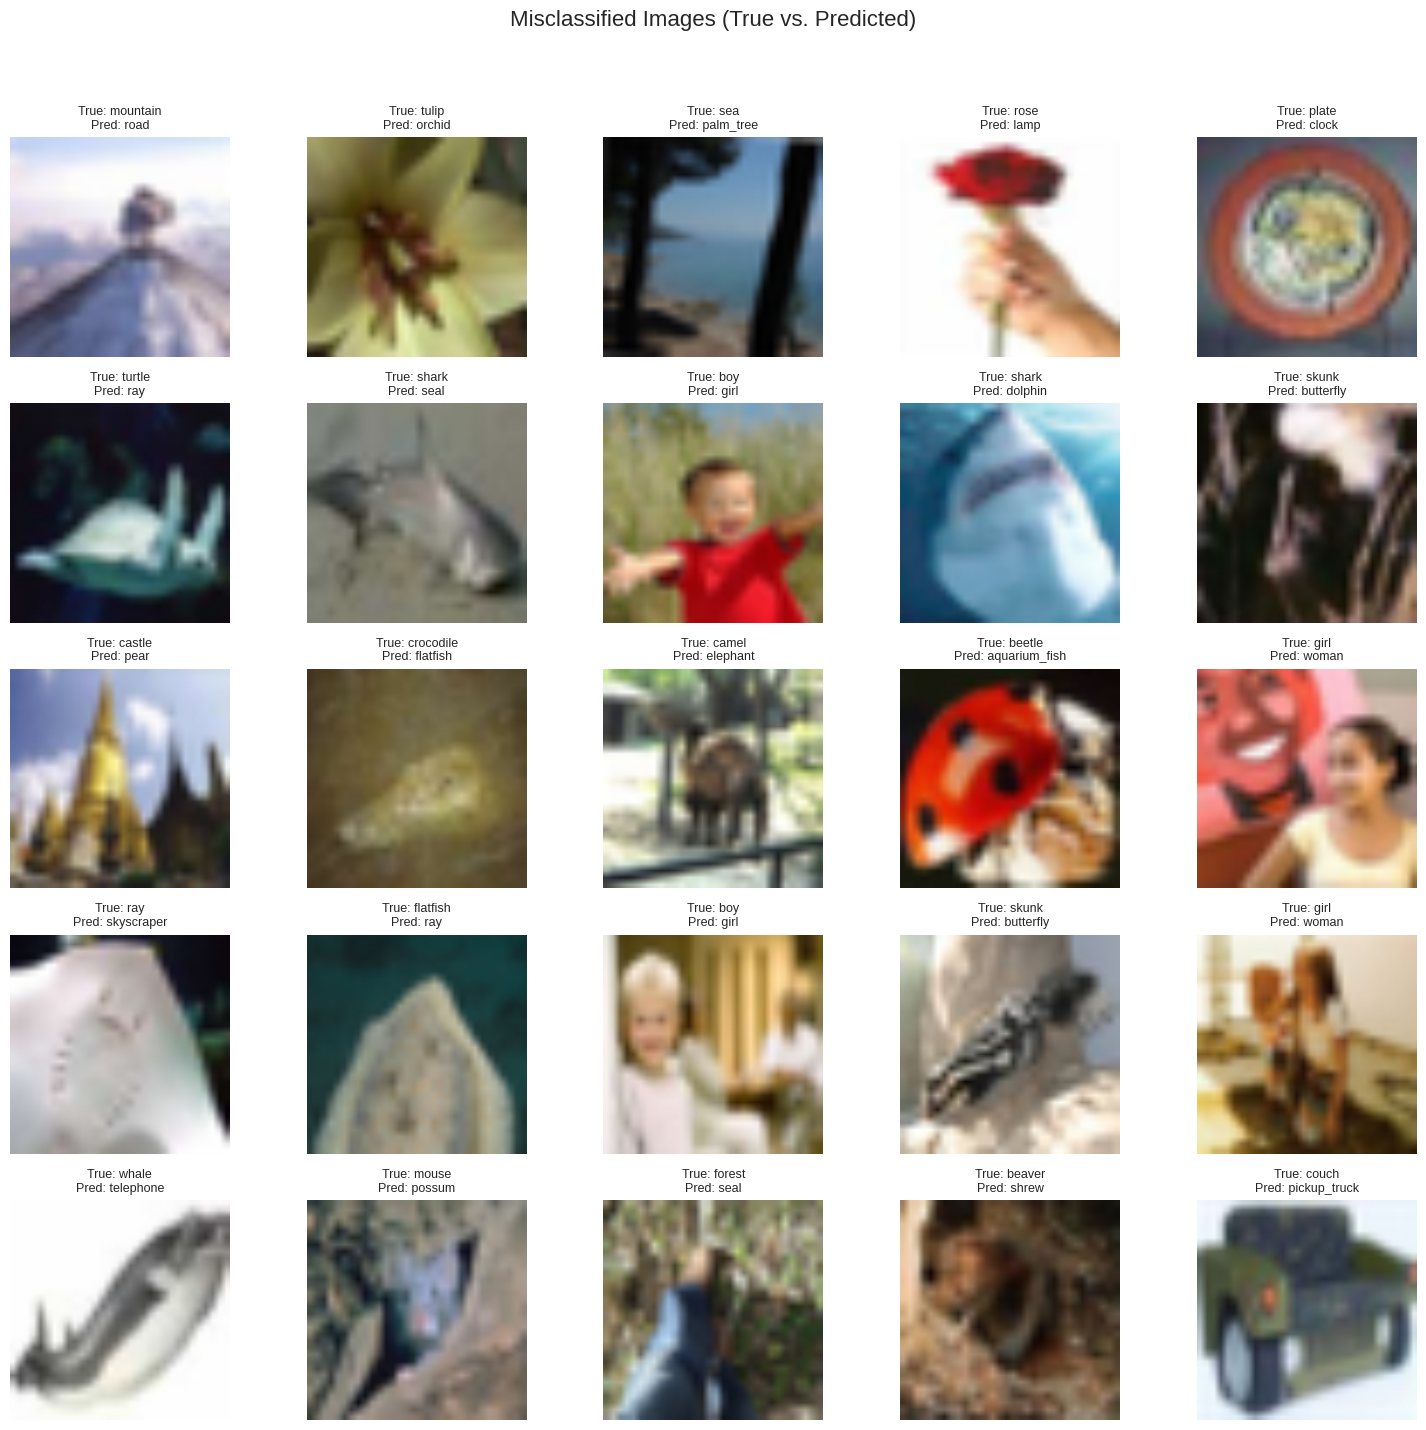

Accuracy history plot saved to 2_ResNet18_accuracy_history.png


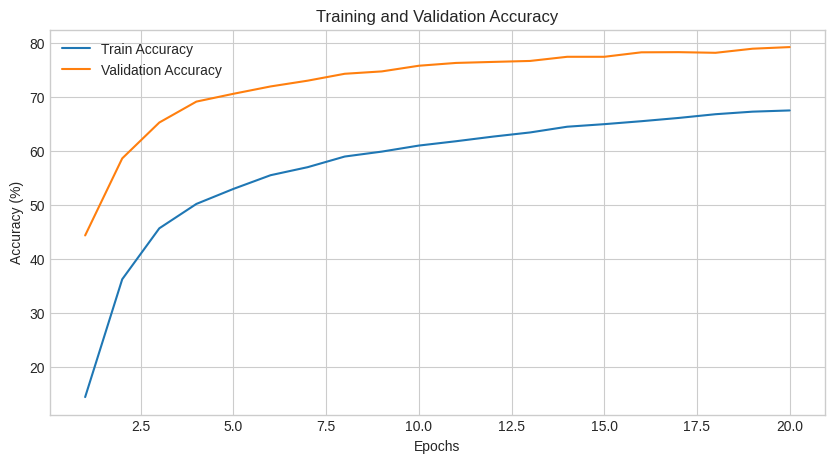

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMG_SIZE = 224
USE_AUGMENTATION = True
DATA_DIR = './data_cifar100'
NUM_WORKERS = 40
MODEL_NAME = "2_ResNet18" # Define model name for saving files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# ---> NEW: Get CIFAR-100 class names <---
class_names = get_cifar100_class_names(DATA_DIR)
num_classes = len(class_names) # Should be 100

print(f"Đang tải dữ liệu CIFAR-100 (resize: {IMG_SIZE}x{IMG_SIZE})...")
train_loader, test_loader, _ = get_cifar100_loaders( # Use num_classes from class_names
    batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    use_augmentation=USE_AUGMENTATION,
    num_workers=NUM_WORKERS
)

if train_loader is None:
    print("Không thể tải dữ liệu. Kết thúc chương trình.")
    exit()

print("Khởi tạo ResNet18 pre-trained model...")
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
print(f"Đã thay thế lớp cuối cùng bằng lớp Linear({num_ftrs}, {num_classes})")

print("Bắt đầu fine-tuning ResNet18...")
# ---> Capture the returned model and histories <---
trained_model, train_history, test_history = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, device, model_name=MODEL_NAME
)

# --- Final Evaluation and Visualization (after training loop) ---
print("\n--- Performing Final Evaluation on Test Set ---")
# ---> Use the trained model (potentially the best loaded one) <---
final_metrics = evaluate_model(trained_model, test_loader, device, num_classes, class_names)

# ---> Plot Confusion Matrix <---
if 'confusion_matrix' in final_metrics:
    plot_confusion_matrix(final_metrics['confusion_matrix'], class_names,
                            filename=f'{MODEL_NAME}_confusion_matrix.png',
                            figsize=(25, 25)) # Adjust size as needed

# ---> Visualize Misclassified Images <---
visualize_misclassified(trained_model, test_loader, device, class_names,
                        num_images=25, # Number of images to show
                        filename_prefix=f'{MODEL_NAME}_misclassified')

# (Optional) Plot Training/Validation Accuracy History
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_history, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'{MODEL_NAME}_accuracy_history.png')
print(f"Accuracy history plot saved to {MODEL_NAME}_accuracy_history.png")
plt.show()